In [1]:
import tensorflow as tf
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICE"]="1"
import scipy
import csv
import cv2
import math
import numpy as np
import matplotlib.pyplot as plt
import random
from PIL import Image
import SimpleITK as sitk

%matplotlib inline

In [2]:
# 10 fold
num_train=math.ceil((154+93)/10 *9)
print( num_train)
num_test=math.floor((154+93)/10 *1)
print(num_test)

223
24


In [3]:
from PIL import Image
import numpy as np
import skimage.io as io

import csv

def _bytes_feature(value):
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _int64_feature(value):
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))


# Let's collect the real images to later on compare
# to the reconstructed ones
def to_binary(train_csv,tfrecords_filename):
    writer = tf.python_io.TFRecordWriter(tfrecords_filename)
    original_images = []
    imageReader = csv.reader(open(train_csv), delimiter=',')
    #skin header
    next(imageReader)
    iter=0
    for row in imageReader:
    
        img_path,mask_path=row
#         print(img_path,mask_path)
        img = np.array(Image.open(img_path))
        mask = np.array(Image.open(mask_path))
        height = img.shape[0]
        width = img.shape[1]
         # Put in the original images into array
        # Just for future check for correctness
        original_images.append((img, mask))
        img_raw = img.tostring()
        mask_raw = mask.tostring()

        example = tf.train.Example(features=tf.train.Features(feature={
        'height': _int64_feature(height),
        'width': _int64_feature(width),
        'image_raw': _bytes_feature(img_raw),
        'mask_raw': _bytes_feature(mask_raw)}))

        writer.write(example.SerializeToString())
        iter+=1
    writer.close()
    print('conversion done with{} '.format(iter))
# train binary file generate
tfrecords_filename = './fengkai/lung_nodule_training.tfrecords'
train_csv= './fengkai/train_nodule.csv'
to_binary(train_csv,tfrecords_filename)
# test binary file generate
tfrecords_filename = './fengkai/lung_nodule_testing.tfrecords'
train_csv= './fengkai/test_nodule.csv'
to_binary(train_csv,tfrecords_filename)

conversion done with223 
conversion done with24 


In [3]:
#decode tfrecord
def read_and_decode(tfrecords_filename,if_aug,new_height,new_width,batch_size):
    # always queue the file name 

    filename_queue = tf.train.string_input_producer([tfrecords_filename])
    reader = tf.TFRecordReader()
    key, serialized_example = reader.read(filename_queue)

    features = tf.parse_single_example(
      serialized_example,
      # Defaults are not specified since both keys are required.
      features={
        'height': tf.FixedLenFeature([], tf.int64),
        'width': tf.FixedLenFeature([], tf.int64),
        'image_raw': tf.FixedLenFeature([], tf.string),
        'mask_raw': tf.FixedLenFeature([], tf.string)
        })

    image = tf.decode_raw(features['image_raw'], tf.uint8)
    annotation = tf.decode_raw(features['mask_raw'], tf.uint8)

    height = tf.cast(features['height'], tf.int32)
    width = tf.cast(features['width'], tf.int32)

    image_shape = [height, width, 1]
    annotation_shape = [height, width, 1]
    #1D to 3D 
    image = tf.reshape(image,image_shape)
    annotation = tf.reshape(annotation, annotation_shape)
    # add fake color 
#     image=tf.image.grayscale_to_rgb(image)
    resized_image=tf.image.resize_images(image,[new_height,new_width],
                                                method=tf.image.ResizeMethod.BILINEAR)

    resized_annotation=tf.image.resize_images(annotation,[new_height,new_width],
                                                method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    # if augment the image and maskr
    if if_aug:


        r_num=tf.random_uniform([1],minval=-0.01,maxval=0.01)

        resized_image=tf.contrib.image.rotate(resized_image,angles=r_num)
        resized_annotation=tf.contrib.image.rotate(resized_annotation,angles=r_num,interpolation='NEAREST')
        resized_image=tf.image.random_contrast(resized_image,lower=0.5,upper=0.9)
        resized_image=tf.image.random_brightness(resized_image,max_delta=0.1)
        
#         tf.set_random_seed(1234)
        
#         resized_image=tf.contrib.keras.preprocessing.image.random_zoom(x=resized_image,zoom_range=0.9,
#         row_axis=0,
#         col_axis=1,
#         channel_axis=2)
        
#         resized_annotation=tf.contrib.keras.preprocessing.image.random_zoom(x=resized_annotation,zoom_range=0.9,
#         row_axis=0,
#         col_axis=1,
#         channel_axis=2)
#     # random crop 
        
  

    ## no aug
    resized_image=tf.divide(resized_image,tf.reduce_max(resized_image))
    resized_annotation=tf.divide(resized_annotation,255)
    resized_annotation=tf.not_equal(resized_annotation,0)
    
       
    images, annotations = tf.train.shuffle_batch( [resized_image, resized_annotation],
                                                 batch_size=batch_size,
                                                 capacity=300,
                                                 num_threads=2,
                                                 min_after_dequeue=20)

    return images, annotations
# # # visualize if the binary is ok

# tfrecords_filename = './fengkai/lung_nodule_testing.tfrecords'
# img_batch_op,mask_batch_op=read_and_decode(tfrecords_filename,if_aug=True,new_height=384,new_width=384,batch_size=2)


# config = tf.ConfigProto()
# config.gpu_options.allow_growth = True
# session = tf.Session(config=config)
# with session as sess:
#     # Start populating the filename queue.
#     coord = tf.train.Coordinator()
#     threads = tf.train.start_queue_runners(coord=coord)
#     sess.run(tf.global_variables_initializer())
    
#     for iter in range(0,200,2):
#         img_batch,mask_batch=sess.run([img_batch_op,mask_batch_op])
#         # plot to see the result match
#         print(np.max(img_batch[0,:,:,0]),np.median(mask_batch[0,:,:,0]))
#         plt.subplot(121)
#         plt.imshow(img_batch[0,:,:,0],cmap='gray')
#         plt.subplot(122)
# #         print(mask_batch.shape)
#         plt.imshow(mask_batch[0,:,:,0],cmap='gray')
#         plt.show()


#     print('csv_read ok')
#     coord.request_stop()
#     coord.join(threads) 

In [4]:
# layer U-net
def conv_conv_pool(input_, n_filters, training, name, pool=True, activation=tf.nn.relu):
    """{Conv -> BN -> RELU}x2 -> {Pool, optional}
    Args:
        input_ (4-D Tensor): (batch_size, H, W, C)
        n_filters (list): number of filters [int, int]
        training (1-D Tensor): Boolean Tensor
        name (str): name postfix
        pool (bool): If True, MaxPool2D
        activation: Activaion functions
    Returns:
        net: output of the Convolution operations
        pool (optional): output of the max pooling operations
    """
    net = input_

    with tf.variable_scope("layer{}".format(name)):
        for i, F in enumerate(n_filters):
            net = tf.layers.conv2d(net, F, (3, 3), activation=None, padding='same', name="conv_{}".format(i + 1))
            tf.keras.layers.SpatialDropout2D(rate=0.5,data_format="channels_last")(net)
            net = tf.layers.batch_normalization(net, training=training, name="bn_{}".format(i + 1))
             # remove bn
            net = activation(net, name="relu{}_{}".format(name, i + 1))
            

        if pool is False:
            return net

        pool = tf.layers.max_pooling2d(net, (2, 2), strides=(2, 2), name="pool_{}".format(name))

        return net, pool


def upsample_concat(inputA, input_B, name):
    """Upsample `inputA` and concat with `input_B`
    Args:
        input_A (4-D Tensor): (N, H, W, C)
        input_B (4-D Tensor): (N, 2*H, 2*H, C2)
        name (str): name of the concat operation
    Returns:
        output (4-D Tensor): (N, 2*H, 2*W, C + C2)
    """
    upsample = upsampling_2D(inputA, size=(2, 2), name=name)

    return tf.concat([upsample, input_B], axis=-1, name="concat_{}".format(name))


def upsampling_2D(tensor, name, size=(2, 2)):
    """Upsample/Rescale `tensor` by size
    Args:
        tensor (4-D Tensor): (N, H, W, C)
        name (str): name of upsampling operations
        size (tuple, optional): (height_multiplier, width_multiplier)
            (default: (2, 2))
    Returns:
        output (4-D Tensor): (N, h_multiplier * H, w_multiplier * W, C)
    """
    H, W, _ = tensor.get_shape().as_list()[1:]

    H_multi, W_multi = size
    target_H = H * H_multi
    target_W = W * W_multi

    return tf.image.resize_nearest_neighbor(tensor, (target_H, target_W), name="upsample_{}".format(name))


def make_unet(X, training):
    """Build a U-Net architecture
    Args:
        X (4-D Tensor): (N, H, W, C)
        training (1-D Tensor): Boolean Tensor is required for batchnormalization layers
    Returns:
        output (4-D Tensor): (N, H, W, C)
            Same shape as the `input` tensor
    Notes:
        U-Net: Convolutional Networks for Biomedical Image Segmentation
        https://arxiv.org/abs/1505.04597
    """
    
    net = tf.layers.conv2d(X, 3, (1, 1), name="color_space_adjust")
    conv1, pool1 = conv_conv_pool(net, [8, 8], training, name=1)
#     tf.keras.layers.SpatialDropout2D(rate=0.5,data_format="channels_last")
    conv2, pool2 = conv_conv_pool(pool1, [16, 16], training, name=2)
#     tf.keras.layers.SpatialDropout2D(rate=0.5,data_format="channels_last")
    conv3, pool3 = conv_conv_pool(pool2, [32, 32], training, name=3)
#     tf.keras.layers.SpatialDropout2D(rate=0.5,data_format="channels_last")
    conv4, pool4 = conv_conv_pool(pool3, [64, 64], training, name=4)
#     tf.keras.layers.SpatialDropout2D(rate=0.5,data_format="channels_last")
    conv5 = conv_conv_pool(pool4, [128, 128], training, name=5, pool=False)
#     tf.keras.layers.SpatialDropout2D(rate=0.5,data_format="channels_last")
    up6 = upsample_concat(conv5, conv4, name=6)
    conv6 = conv_conv_pool(up6, [64, 64], training, name=6, pool=False)

    up7 = upsample_concat(conv6, conv3, name=7)
    conv7 = conv_conv_pool(up7, [32, 32], training, name=7, pool=False)

    up8 = upsample_concat(conv7, conv2, name=8)
    conv8 = conv_conv_pool(up8, [16, 16], training, name=8, pool=False)

    up9 = upsample_concat(conv8, conv1, name=9)
    conv9 = conv_conv_pool(up9, [8, 8], training, name=9, pool=False)
    conv10=tf.layers.conv2d(conv9, 1, (1, 1), name='final', activation=tf.nn.sigmoid, padding='same')
    
    return conv10



In [5]:
# loss define and train op
def IOU_(y_pred, y_true):
    """Returns a (approx) IOU score
    intesection = y_pred.flatten() * y_true.flatten()
    Then, IOU = 2 * intersection / (y_pred.sum() + y_true.sum() + 1e-7) + 1e-7
    Args:
        y_pred (4-D array): (N, H, W, 1)
        y_true (4-D array): (N, H, W, 1)
    Returns:
        float: IOU score
    """
    
    
    H, W, _ = y_pred.get_shape().as_list()[1:]

    pred_flat = tf.reshape(y_pred, [-1, H * W])
    true_flat = tf.reshape(y_true, [-1, H * W])

    #to 0-1
    pred_flat=pred_flat/(tf.reduce_max(pred_flat)+ 1e-7)
    true_flat=true_flat/(tf.reduce_max(true_flat)+ 1e-7)

    intersection =  2*tf.reduce_sum(pred_flat * true_flat, axis=1) + 1e-7
    denominator = tf.reduce_sum(pred_flat, axis=1) + tf.reduce_sum(true_flat, axis=1) + 1e-7

    return tf.reduce_mean(intersection / denominator)


def make_train_op(y_pred, y_true):
    """Returns a training operation
    Loss function = - IOU(y_pred, y_true)
    IOU is
        (the area of intersection)
        --------------------------
        (the area of two boxes)
    Args:
        y_pred (4-D Tensor): (N, H, W, 1)
        y_true (4-D Tensor): (N, H, W, 1)
    Returns:
        train_op: minimize operation
    """
    loss =-IOU_(y_pred, y_true)

    global_step = tf.train.get_or_create_global_step()

    optim = tf.train.AdamOptimizer()
    return optim.minimize(loss, global_step=global_step)


In [29]:

import time
logdir='./fengkai/Unet_nodule'
ckdir ='./fengkai/Unet_nodule_model'
if not os.path.exists(logdir):
    os.mkdir(logdir)

current_time = time.strftime("%m/%d/%H/%M/%S")
train_logdir = os.path.join(logdir, "train", current_time)
test_logdir = os.path.join(logdir, "test", current_time)
# parameter setting
n_train=223
n_test=24
new_height=512
new_width=new_height
epochs=800
batch_size=4
tf.reset_default_graph()
X = tf.placeholder(tf.float32, shape=[None, new_width, new_height, 1], name="X")
y = tf.placeholder(tf.float32, shape=[None, new_width, new_height, 1], name="y")
mode = tf.placeholder(tf.bool, name="mode")

pred = make_unet(X, mode)
# pred=tf.cast(tf.not_equal(pred,0),dtype=tf.float32)
tf.add_to_collection("inputs", X)
tf.add_to_collection("inputs", mode)
tf.add_to_collection("outputs", pred)

tf.summary.histogram("Predicted_Mask", pred)
tf.summary.image("Predicted_Mask", pred)

update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)

with tf.control_dependencies(update_ops):
    train_op = make_train_op(pred, y)

IOU_op = IOU_(pred, y)
IOU_op = tf.Print(IOU_op, [IOU_op])
tf.summary.scalar("IOU", IOU_op)





#train image mask batch op
#train image mask batch op
train_tfrecords_filename = './fengkai/lung_nodule_training.tfrecords'
train_img_batch_op,train_mask_batch_op=read_and_decode(train_tfrecords_filename,if_aug=True,new_height=new_height,new_width=new_width,batch_size=batch_size)
#test image mask batch op
test_tfrecords_filename = './fengkai/lung_nodule_testing.tfrecords'
test_img_batch_op,test_mask_batch_op=read_and_decode(test_tfrecords_filename,if_aug=False,new_height=new_height,new_width=new_width,batch_size=batch_size)


summary_op = tf.summary.merge_all()


config = tf.ConfigProto(gpu_options=tf.GPUOptions(per_process_gpu_memory_fraction=0.2))

# config.gpu_options.allow_growth = True
session = tf.Session(config=config)
with session as sess:
    # Start populating the filename queue.
    train_summary_writer = tf.summary.FileWriter(train_logdir, sess.graph)
    test_summary_writer = tf.summary.FileWriter(test_logdir)

#     coord = tf.train.Coordinator()
#     threads = tf.train.start_queue_runners(coord=coord)
    sess.run(tf.global_variables_initializer())
    saver = tf.train.Saver()
    if os.path.exists(ckdir) and tf.train.checkpoint_exists(ckdir):
        latest_check_point = tf.train.latest_checkpoint(ckdir)
        saver.restore(sess, latest_check_point)

    else:
        try:
            os.rmdir(ckdir)
        except FileNotFoundError:
            pass
        os.mkdir(ckdir)


    try:
        global_step = tf.train.get_global_step(sess.graph)

        coord = tf.train.Coordinator()
        threads = tf.train.start_queue_runners(coord=coord)
        counter_till_break=0
        for epoch in range(epochs):
            train_iou=0
            for step in range(0, n_train, batch_size):

                X_batch, y_batch = sess.run([train_img_batch_op,train_mask_batch_op])

                _, step_iou, step_summary, global_step_value = sess.run(
                    [train_op, IOU_op, summary_op, global_step],
                    feed_dict={X: X_batch,
                               y: y_batch,
                               mode: True})
                train_iou += step_iou * X_batch.shape[0]

                train_summary_writer.add_summary(step_summary, global_step_value)

            total_iou = 0
            for step in range(0, n_test, batch_size):
                X_test, y_test = sess.run([test_img_batch_op,test_mask_batch_op])
                step_iou, step_summary = sess.run(
                    [IOU_op, summary_op],
                    feed_dict={X: X_test,
                               y: y_test,
                               mode: False})

                total_iou += step_iou * X_test.shape[0]

                test_summary_writer.add_summary(step_summary, (epoch + 1) * (step + 1))


            print("epoch :{},IOU for training is {} for test  is {} ".format(epoch,train_iou/n_train,
                                                                             total_iou/n_test))

            if total_iou/n_test > 0.15 and total_iou/n_test< 0.16:
                print('saving the checkpoint')
                counter_till_break+=1
                saver.save(sess, "{}/model{}.ckpt".format(ckdir,epoch))
            if counter_till_break > 5:
                break

    finally:
        coord.request_stop()
        coord.join(threads)
#         saver.save(sess, "{}/model{}.ckpt".format(ckdir,epoch))


epoch :0,IOU for training is 0.005182954188316592 for test  is 0.001647330272505203 
epoch :1,IOU for training is 0.005586572816312149 for test  is 0.003743991124792956 
epoch :2,IOU for training is 0.006297147026793987 for test  is 0.0045916645710046096 
epoch :3,IOU for training is 0.0060583180951883754 for test  is 0.00393162143882364 
epoch :4,IOU for training is 0.00804781187912739 for test  is 0.006997284828685224 
epoch :5,IOU for training is 0.008369872720323978 for test  is 0.006400493361676733 
epoch :6,IOU for training is 0.009048607233794815 for test  is 0.005104673153255135 
epoch :7,IOU for training is 0.010071788187885547 for test  is 0.004268850859565039 
epoch :8,IOU for training is 0.011465739270909768 for test  is 0.005006366622789453 
epoch :9,IOU for training is 0.01180265300331986 for test  is 0.007107229088433087 
epoch :10,IOU for training is 0.013539946612552579 for test  is 0.0024170840576213473 
epoch :11,IOU for training is 0.015345674188830618 for test  is 

epoch :97,IOU for training is 0.2233757997728713 for test  is 0.07864999889404582 
epoch :98,IOU for training is 0.2660247950096574 for test  is 0.052418037928608406 
epoch :99,IOU for training is 0.23467928597326052 for test  is 0.12308248404674534 
epoch :100,IOU for training is 0.28990502466592066 for test  is 0.11427568531712495 
epoch :101,IOU for training is 0.267910581647172 for test  is 0.1956369529167811 
epoch :102,IOU for training is 0.2291468185344079 for test  is 0.13872453923239902 
epoch :103,IOU for training is 0.2671232481649496 for test  is 0.19731510499923388 
epoch :104,IOU for training is 0.2444694419912789 for test  is 0.12363262632800816 
epoch :105,IOU for training is 0.29520332513625525 for test  is 0.21951883984424117 
epoch :106,IOU for training is 0.27213156371300357 for test  is 0.09741142510954622 
epoch :107,IOU for training is 0.27433423015798497 for test  is 0.24192055687308311 
epoch :108,IOU for training is 0.28984287175406687 for test  is 0.062938572

INFO:tensorflow:Restoring parameters from ./fengkai/Unet_nodule_model/model152.ckpt


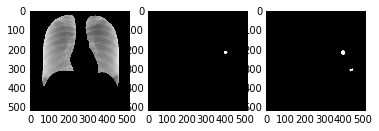

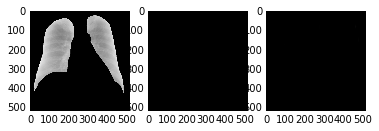

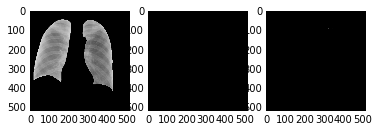

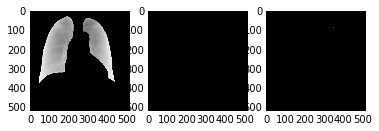

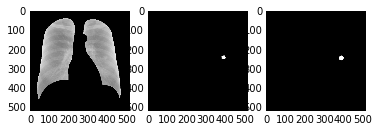

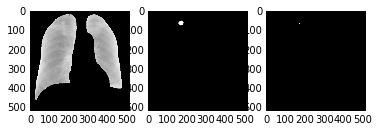

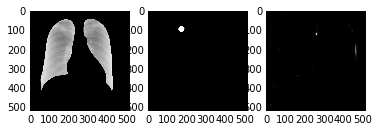

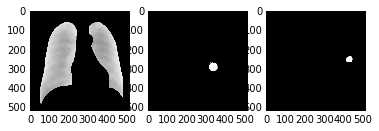

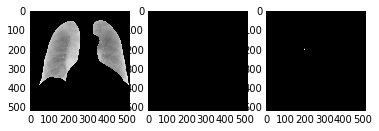

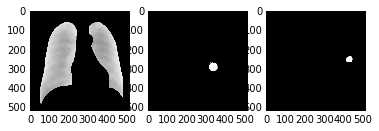

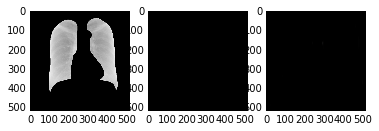

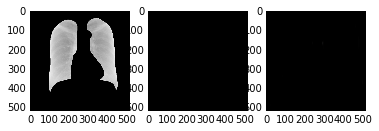

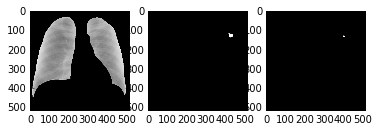

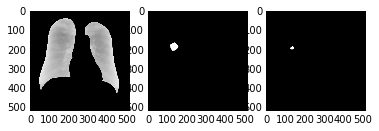

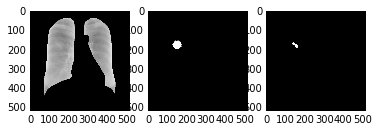

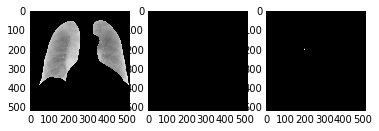

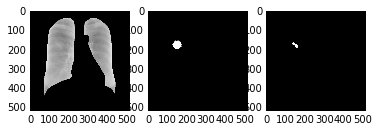

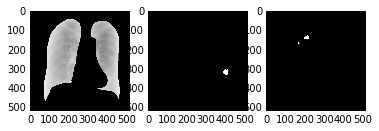

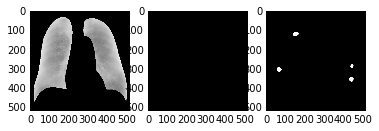

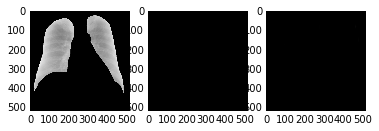

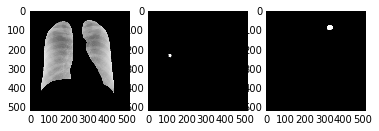

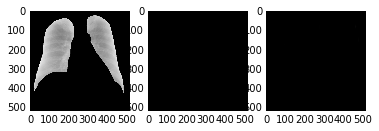

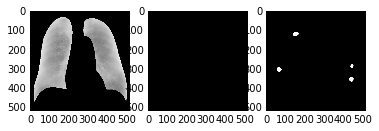

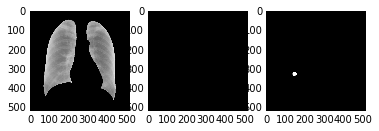

INFO:tensorflow:Error reported to Coordinator: <class 'tensorflow.python.framework.errors_impl.CancelledError'>, Enqueue operation was cancelled
	 [[Node: input_producer_1/input_producer_1_EnqueueMany = QueueEnqueueManyV2[Tcomponents=[DT_STRING], timeout_ms=-1, _device="/job:localhost/replica:0/task:0/device:CPU:0"](input_producer_1, input_producer_1/RandomShuffle)]]


In [30]:
# best test accuracy on epoch 104

# for visualization

import time
logdir='./fengkai/Unet_nodule'
ckdir ='./fengkai/Unet_nodule_model'
if not os.path.exists(logdir):
    os.mkdir(logdir)

current_time = time.strftime("%m/%d/%H/%M/%S")
train_logdir = os.path.join(logdir, "train", current_time)
test_logdir = os.path.join(logdir, "test", current_time)
# parameter setting
n_train=223
n_test=24
new_height=512
new_width=new_height
epochs=1
batch_size=1
tf.reset_default_graph()
X = tf.placeholder(tf.float32, shape=[None, new_width, new_height, 1], name="X")
y = tf.placeholder(tf.float32, shape=[None, new_width, new_height, 1], name="y")
mode = tf.placeholder(tf.bool, name="mode")

pred = make_unet(X, mode)

tf.add_to_collection("inputs", X)
tf.add_to_collection("inputs", mode)
tf.add_to_collection("outputs", pred)

tf.summary.histogram("Predicted_Mask", pred)
tf.summary.image("Predicted_Mask", pred)

update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)

with tf.control_dependencies(update_ops):
    train_op = make_train_op(pred, y)

IOU_op = IOU_(pred, y)
IOU_op = tf.Print(IOU_op, [IOU_op])
tf.summary.scalar("IOU", IOU_op)





#train image mask batch op
#train image mask batch op
train_tfrecords_filename = './fengkai/lung_nodule_training.tfrecords'
train_img_batch_op,train_mask_batch_op=read_and_decode(train_tfrecords_filename,if_aug=True,new_height=new_height,new_width=new_width,batch_size=batch_size)
#test image mask batch op
test_tfrecords_filename = './fengkai/lung_nodule_testing.tfrecords'
test_img_batch_op,test_mask_batch_op=read_and_decode(test_tfrecords_filename,if_aug=False,new_height=new_height,new_width=new_width,batch_size=batch_size)


summary_op = tf.summary.merge_all()
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)
with session as sess:
    # Start populating the filename queue.
    train_summary_writer = tf.summary.FileWriter(train_logdir, sess.graph)
    test_summary_writer = tf.summary.FileWriter(test_logdir)

#     coord = tf.train.Coordinator()
#     threads = tf.train.start_queue_runners(coord=coord)
    sess.run(tf.global_variables_initializer())
    saver = tf.train.Saver()
    if os.path.exists(ckdir) and tf.train.checkpoint_exists(ckdir):
        latest_check_point = tf.train.latest_checkpoint(ckdir)
        saver.restore(sess, latest_check_point)

        global_step = tf.train.get_global_step(sess.graph)

        coord = tf.train.Coordinator()
        threads = tf.train.start_queue_runners(coord=coord)

        for epoch in range(epochs):

            for step in range(0, n_test, batch_size):
                X_test, y_test = sess.run([test_img_batch_op,test_mask_batch_op])
                image,label,predict = sess.run(
                    [X,y,pred],
                    feed_dict={X: X_test,
                               y: y_test,
                               mode: False})
                plt.subplot(131)
                plt.imshow(image[0,:,:,0],cmap='gray')
                plt.subplot(132)
                plt.imshow(label[0,:,:,0],cmap='gray')
                plt.subplot(133)
                plt.imshow(predict[0,:,:,0],cmap='gray')
                plt.show()

In [30]:
# for visualization

import time
logdir='./fengkai/Unet_nodule'
ckdir ='./fengkai/Unet_nodule_model'
if not os.path.exists(logdir):
    os.mkdir(logdir)

current_time = time.strftime("%m/%d/%H/%M/%S")
train_logdir = os.path.join(logdir, "train", current_time)
test_logdir = os.path.join(logdir, "test", current_time)
# parameter setting
n_train=223
n_test=24
new_height=512
new_width=new_height
epochs=1
batch_size=1
tf.reset_default_graph()
X = tf.placeholder(tf.float32, shape=[None, new_width, new_height, 1], name="X")
y = tf.placeholder(tf.float32, shape=[None, new_width, new_height, 1], name="y")
mode = tf.placeholder(tf.bool, name="mode")

pred = make_unet(X, mode)

tf.add_to_collection("inputs", X)
tf.add_to_collection("inputs", mode)
tf.add_to_collection("outputs", pred)

tf.summary.histogram("Predicted_Mask", pred)
tf.summary.image("Predicted_Mask", pred)

update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)

with tf.control_dependencies(update_ops):
    train_op = make_train_op(pred, y)

IOU_op = IOU_(pred, y)
IOU_op = tf.Print(IOU_op, [IOU_op])
tf.summary.scalar("IOU", IOU_op)




#train image mask batch op
#train image mask batch op
train_tfrecords_filename = './fengkai/lung_nodule_training.tfrecords'
train_img_batch_op,train_mask_batch_op=read_and_decode(train_tfrecords_filename,if_aug=True,new_height=new_height,new_width=new_width,batch_size=batch_size)
#test image mask batch op
test_tfrecords_filename = './fengkai/lung_nodule_testing.tfrecords'
test_img_batch_op,test_mask_batch_op=read_and_decode(test_tfrecords_filename,if_aug=False,new_height=new_height,new_width=new_width,batch_size=batch_size)


summary_op = tf.summary.merge_all()
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)
with session as sess:
    # Start populating the filename queue.
    train_summary_writer = tf.summary.FileWriter(train_logdir, sess.graph)
    test_summary_writer = tf.summary.FileWriter(test_logdir)

#     coord = tf.train.Coordinator()
#     threads = tf.train.start_queue_runners(coord=coord)
    sess.run(tf.global_variables_initializer())
    saver = tf.train.Saver()
    if os.path.exists(ckdir) and tf.train.checkpoint_exists(ckdir):
        latest_check_point = tf.train.latest_checkpoint(ckdir)
        saver.restore(sess, latest_check_point)

        global_step = tf.train.get_global_step(sess.graph)

        coord = tf.train.Coordinator()
        threads = tf.train.start_queue_runners(coord=coord)

        for epoch in range(epochs):

            for step in range(0, n_test, batch_size):
                X_test, y_test = sess.run([test_img_batch_op,test_mask_batch_op])
                image,label,predict = sess.run(
                    [X,y,pred],
                    feed_dict={X: X_test,
                               y: y_test,
                               mode: False})
                
                image_2d=image[0,:,:,0]*255
                label_2d=label[0,:,:,0]*255
                predict_2d=predict[0,:,:,0]/np.max(predict[0,:,:,0])*255
                
                cv2.imwrite('./fengkai/U-net-prediction-images/image/{}.png'.format(step),image_2d)
                cv2.imwrite('./fengkai/U-net-prediction-images/label/{}.png'.format(step),label_2d)
                cv2.imwrite('./fengkai/U-net-prediction-images/predict/{}.png'.format(step),predict_2d)
#                 fig=plt.figure()
#                 0-255 才能存
#                 plt.imshow(image[0,:,:,0],cmap='gray')
#                 plt.axis('off')
#                 plt.savefig('./fengkai/U-net-prediction-images/image/{}.png'.format(step), bbox_inches='tight', pad_inches=0)
#                 plt.show()
#                 fig=plt.figure()
#                 plt.imshow(label[0,:,:,0],cmap='gray')
#                 plt.axis('off')
#                 plt.savefig('./fengkai/U-net-prediction-images/label/{}.png'.format(step), bbox_inches='tight', pad_inches=0)
#                 plt.show()
#                 fig=plt.figure()
#                 plt.imshow(predict[0,:,:,0],cmap='gray')
#                 plt.axis('off')
#                 plt.savefig('./fengkai/U-net-prediction-images/predict/{}.png'.format(step), bbox_inches='tight', pad_inches=0)
#                 plt.show()
                

INFO:tensorflow:Restoring parameters from ./fengkai/Unet_nodule_model/model152.ckpt


INFO:tensorflow:Restoring parameters from ./fengkai/Unet_nodule_model/model152.ckpt


INFO:tensorflow:Error reported to Coordinator: <class 'tensorflow.python.framework.errors_impl.CancelledError'>, Enqueue operation was cancelled
	 [[Node: input_producer/input_producer_EnqueueMany = QueueEnqueueManyV2[Tcomponents=[DT_STRING], timeout_ms=-1, _device="/job:localhost/replica:0/task:0/device:CPU:0"](input_producer, input_producer/RandomShuffle)]]


INFO:tensorflow:Error reported to Coordinator: <class 'tensorflow.python.framework.errors_impl.CancelledError'>, Enqueue operation was cancelled
	 [[Node: input_producer/input_producer_EnqueueMany = QueueEnqueueManyV2[Tcomponents=[DT_STRING], timeout_ms=-1, _device="/job:localhost/replica:0/task:0/device:CPU:0"](input_producer, input_producer/RandomShuffle)]]


In [6]:
tp=1+1+1+1+1+1+1+1+1+1
fn=1+1
fp=5+1+4+2+1+1+1+1
recall=tp/(tp+fn)
precision=tp/(tp+fp)
print('After U-net manual')
print('recall={}'.format(recall))
print('precision={}'.format(precision))

After U-net manual
recall=0.8333333333333334
precision=0.38461538461538464


In [28]:
def getROICenters(itk_image, radius):
    itk_image = sitk.BinaryMorphologicalClosing(itk_image, radius)
    itk_image = sitk.ConnectedComponent(itk_image,fullyConnected=False)
    label_shape_analysis = sitk.LabelShapeStatisticsImageFilter()
    nodules = []
    label_shape_analysis.Execute(itk_image)
    num_labels = label_shape_analysis.GetNumberOfLabels()
    backg=0
    label_shape_analysis.SetBackgroundValue(backg)
#    print(num_labels,backg)
    for l_i in range(1, num_labels + 1):
        center = label_shape_analysis.GetCentroid(l_i)
        nodules.append(center)
        print("Center:", center)
    print("found n nodules", len(nodules))
    return nodules

24
/home/fengkai/fengkai/U-net-prediction-images/predict/0.png
Center: (240.0, 168.5)
found n nodules 1


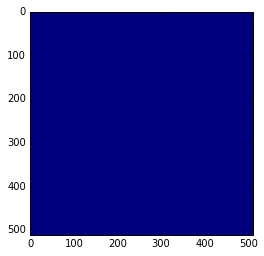

/home/fengkai/fengkai/U-net-prediction-images/predict/1.png
Center: (510.0, 194.5)
found n nodules 1


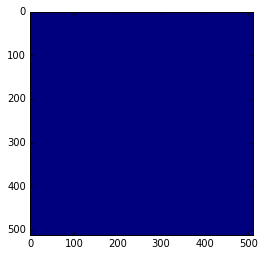

/home/fengkai/fengkai/U-net-prediction-images/predict/2.png
Center: (97.0, 178.0)
found n nodules 1


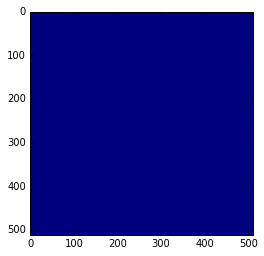

/home/fengkai/fengkai/U-net-prediction-images/predict/3.png
Center: (426.13475177304963, 251.9952718676123)
found n nodules 1


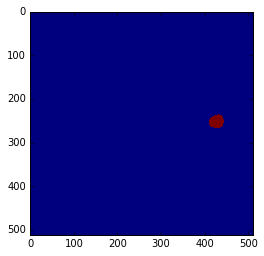

/home/fengkai/fengkai/U-net-prediction-images/predict/4.png
Center: (258.0, 123.0)
found n nodules 1


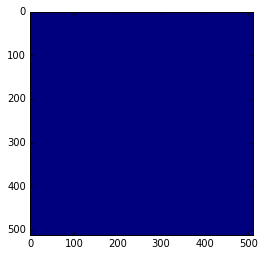

/home/fengkai/fengkai/U-net-prediction-images/predict/5.png
Center: (385.4413646055437, 245.19402985074626)
found n nodules 1


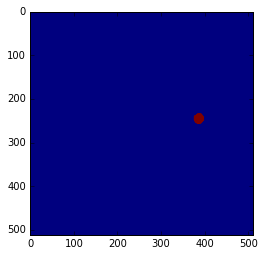

/home/fengkai/fengkai/U-net-prediction-images/predict/6.png
Center: (149.62529832935562, 179.1527446300716)
found n nodules 1


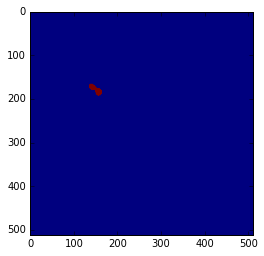

/home/fengkai/fengkai/U-net-prediction-images/predict/7.png
Center: (138.69157392686805, 288.5612082670906)
found n nodules 1


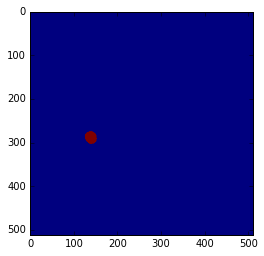

/home/fengkai/fengkai/U-net-prediction-images/predict/8.png
Center: (138.69157392686805, 288.5612082670906)
found n nodules 1


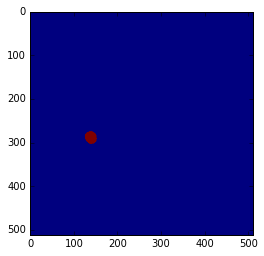

/home/fengkai/fengkai/U-net-prediction-images/predict/9.png
Center: (146.43342036553526, 326.5744125326371)
found n nodules 1


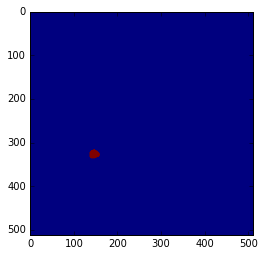

/home/fengkai/fengkai/U-net-prediction-images/predict/10.png
Center: (510.0, 194.5)
found n nodules 1


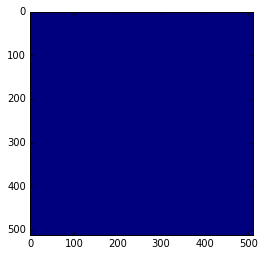

/home/fengkai/fengkai/U-net-prediction-images/predict/11.png
Center: (396.8553459119497, 218.125786163522)
found n nodules 1


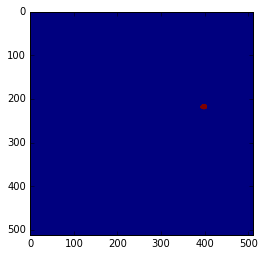

/home/fengkai/fengkai/U-net-prediction-images/predict/12.png
Center: (197.33333333333334, 201.25)
found n nodules 1


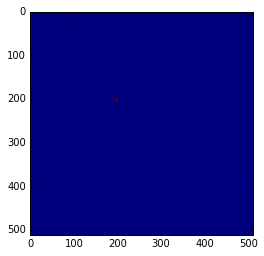

/home/fengkai/fengkai/U-net-prediction-images/predict/13.png
Center: (398.7027027027027, 134.78378378378378)
found n nodules 1


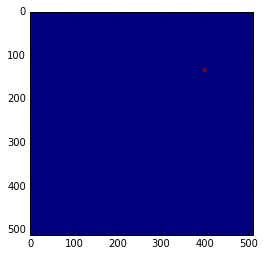

/home/fengkai/fengkai/U-net-prediction-images/predict/14.png
Center: (321.0, 95.0)
found n nodules 1


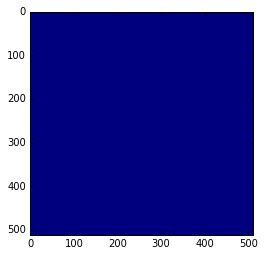

/home/fengkai/fengkai/U-net-prediction-images/predict/15.png
Center: (146.43342036553526, 326.5744125326371)
found n nodules 1


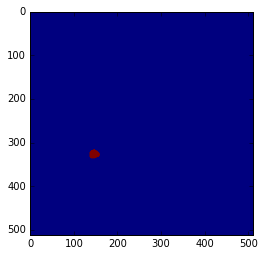

/home/fengkai/fengkai/U-net-prediction-images/predict/16.png
Center: (444.0601503759398, 281.65664160401)
Center: (101.45333333333333, 397.73333333333335)
found n nodules 2


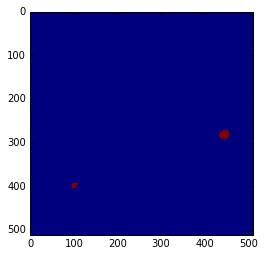

/home/fengkai/fengkai/U-net-prediction-images/predict/17.png
Center: (122.49753694581281, 314.4039408866995)
found n nodules 1


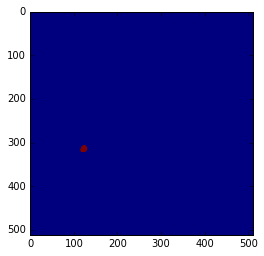

/home/fengkai/fengkai/U-net-prediction-images/predict/18.png
Center: (152.482, 121.694)
Center: (439.48660714285717, 286.36607142857144)
Center: (66.49668874172185, 303.7041942604857)
Center: (436.69417475728153, 354.61893203883494)
found n nodules 4


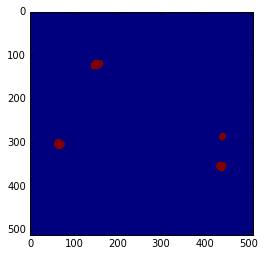

/home/fengkai/fengkai/U-net-prediction-images/predict/19.png
Center: (97.0, 178.0)
found n nodules 1


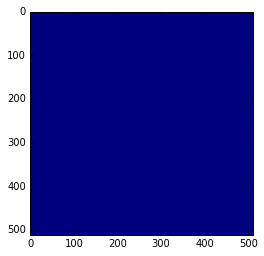

/home/fengkai/fengkai/U-net-prediction-images/predict/20.png
Center: (510.0, 194.5)
found n nodules 1


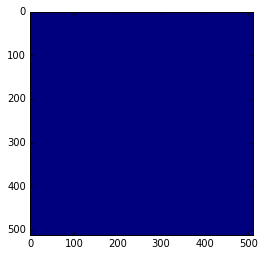

/home/fengkai/fengkai/U-net-prediction-images/predict/21.png
Center: (345.5, 90.5)
found n nodules 1


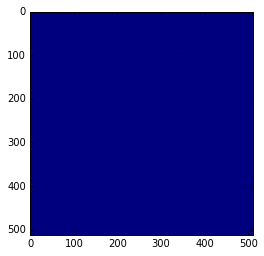

/home/fengkai/fengkai/U-net-prediction-images/predict/22.png
Center: (149.62529832935562, 179.1527446300716)
found n nodules 1


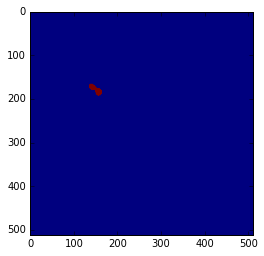

/home/fengkai/fengkai/U-net-prediction-images/predict/23.png
Center: (398.7027027027027, 134.78378378378378)
found n nodules 1


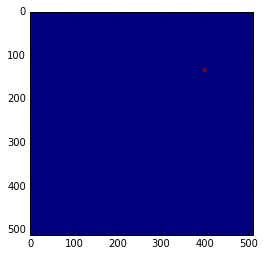

In [39]:
# vector index selection 
# make coordinate file for testresults 
testResultPath = '/home/fengkai/fengkai/U-net-prediction-images/predict/'

import pylab
from pylab import imshow
import csv 

testResult= os.listdir(testResultPath)


totalnumberofTest = len(testResult)-1
print(totalnumberofTest)
split=0.99
coordinateofTest=np.zeros((10000,3))
count =0

allcountbefore=0
for count in range(totalnumberofTest):

    fname = testResultPath+'{}.png'.format(count)
    print(fname)
    itk_image = sitk.ReadImage(fname)
    itk_image_after_cast = sitk.Cast(itk_image, sitk.sitkUInt64)
    slice_sitk = sitk.GetArrayFromImage(itk_image_after_cast)

    up = np.divide(np.max(slice_sitk),1.00000)

    slice_sitk =sitk.BinaryThreshold(itk_image_after_cast,split*up,up,1,0)
    numpy_slice_sitk=sitk.GetArrayFromImage(slice_sitk)
    imshow(numpy_slice_sitk)
    nodules=getROICenters(slice_sitk,10)
    pylab.show()
    labels =len(nodules)
    la=0
    for nodule in nodules:
        coordinateofTest[allcountbefore+la,0]=count # name of file
        coordinateofTest[allcountbefore+la,1]=nodules[la][0]#x 
        coordinateofTest[allcountbefore+la,2]=nodules[la][1]#y
        la = la+1
    
    allcountbefore = allcountbefore+labels
    

with open('./fengkai/coordinateTest.txt', 'a') as f:

    for n,x, y in coordinateofTest: 
        if n !=0:
            f.write('{} {} {}\n'.format(n,x, y))

            


In [ ]:
.

INFO:tensorflow:Restoring parameters from ./fengkai/Unet_nodule_model/model112.ckpt


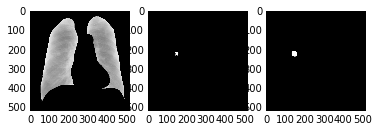

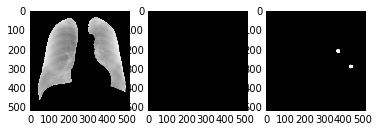

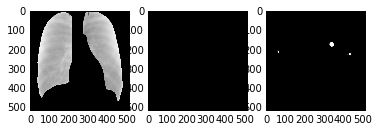

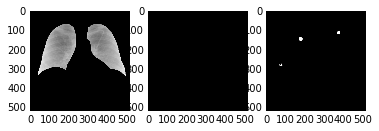

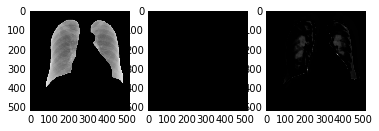

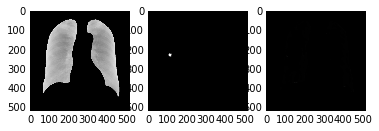

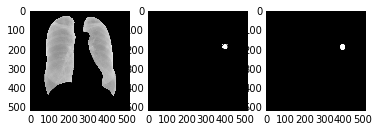

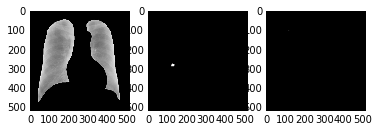

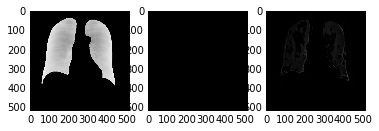

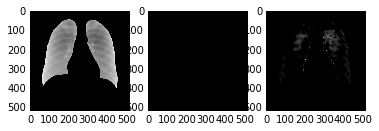

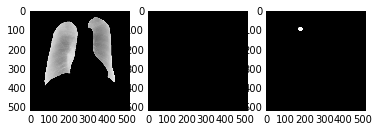

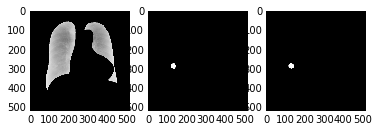

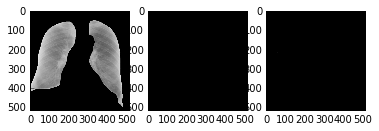

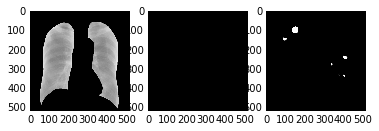

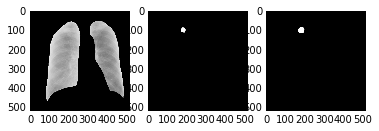

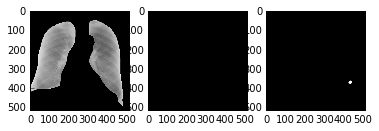

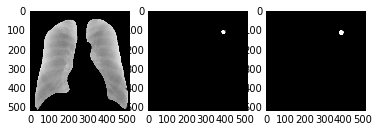

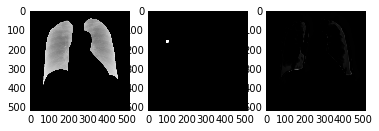

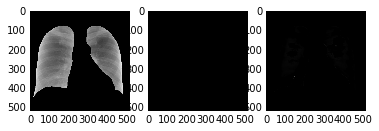

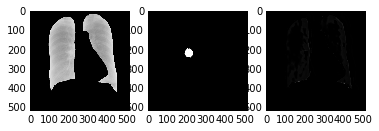

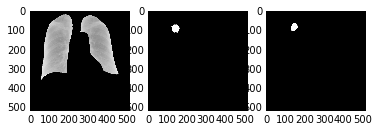

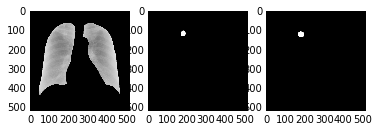

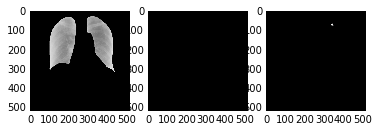

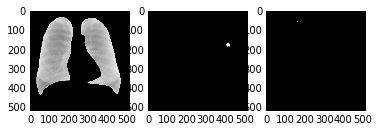

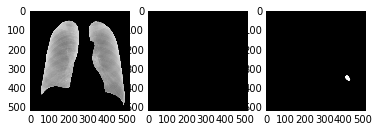

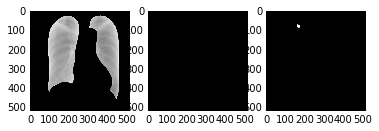

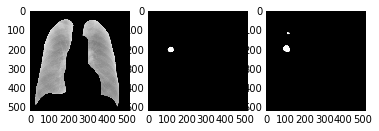

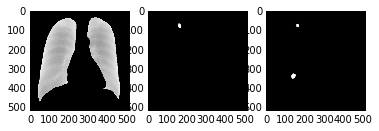

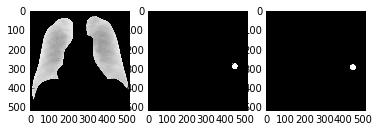

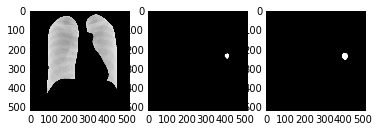

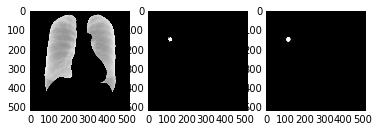

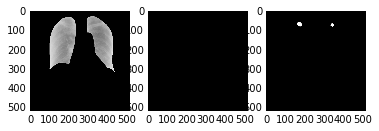

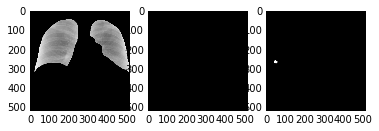

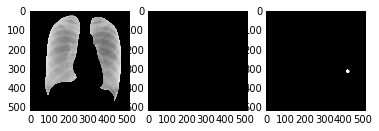

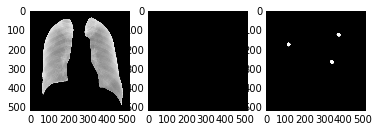

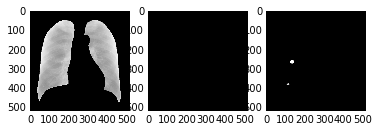

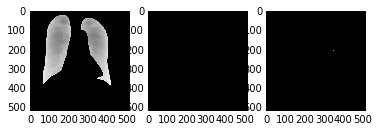

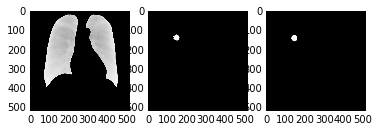

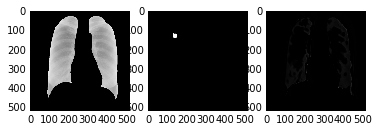

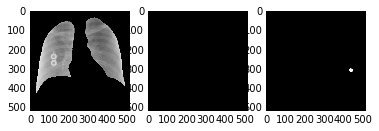

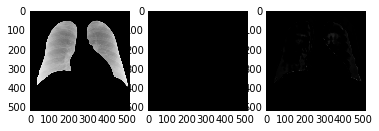

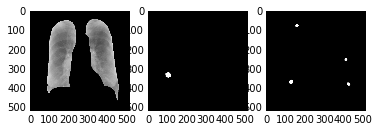

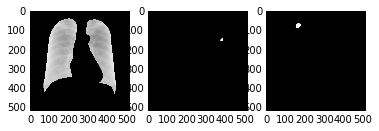

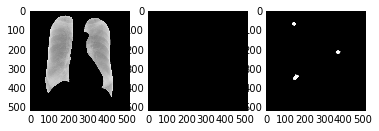

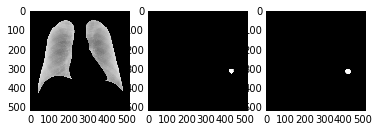

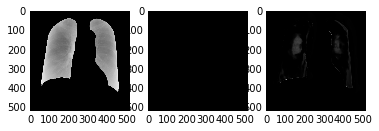

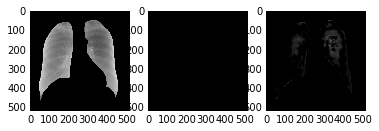

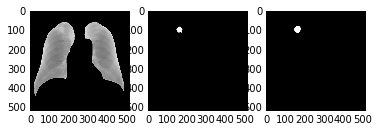

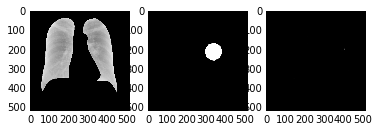

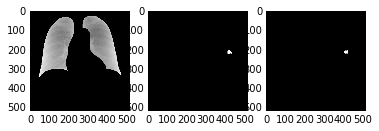

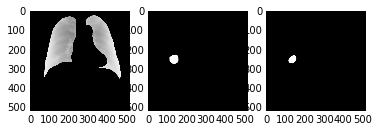

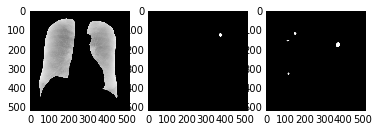

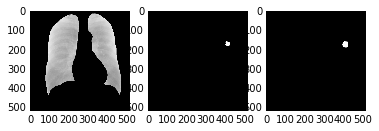

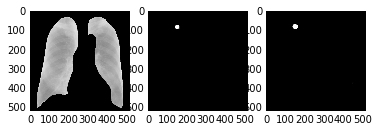

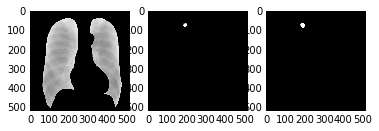

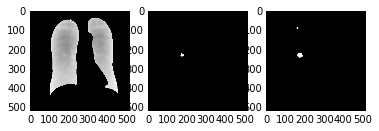

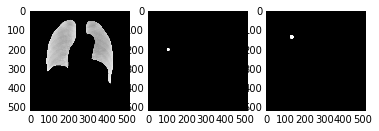

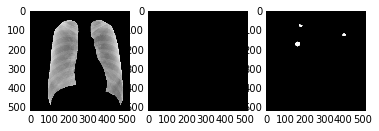

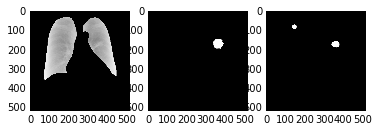

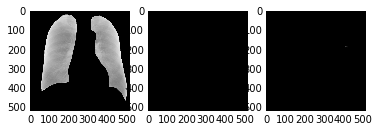

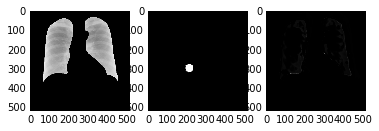

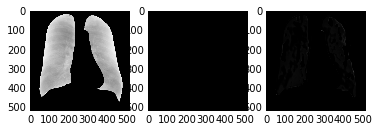

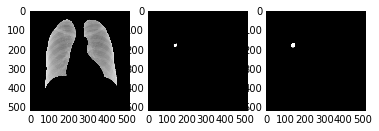

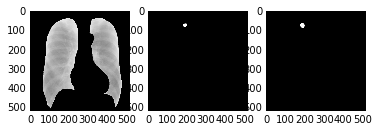

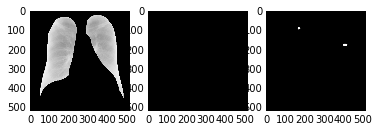

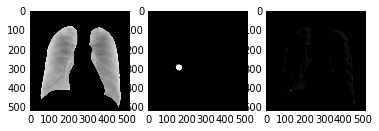

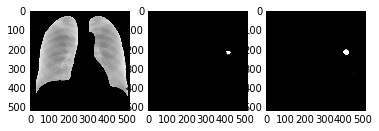

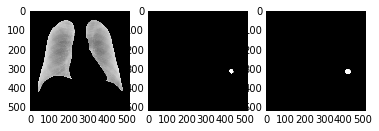

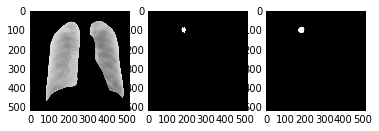

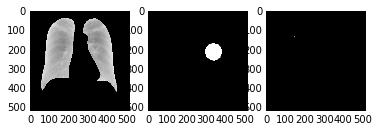

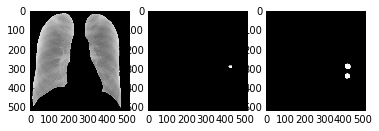

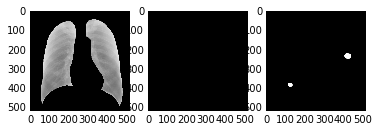

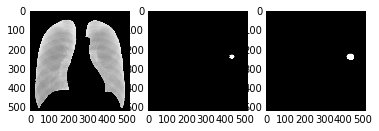

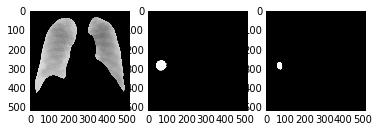

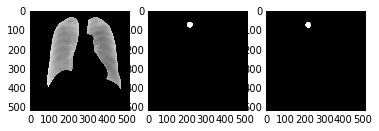

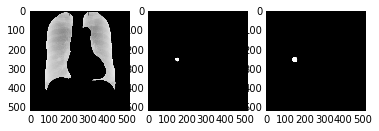

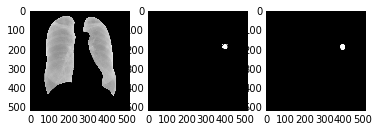

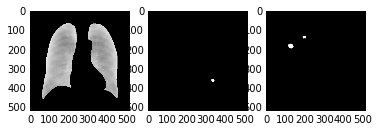

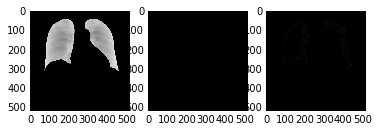

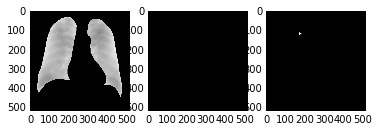

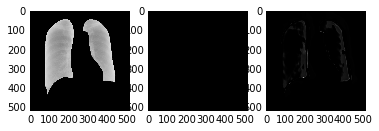

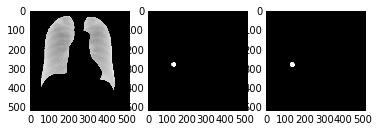

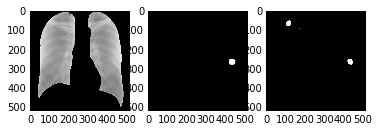

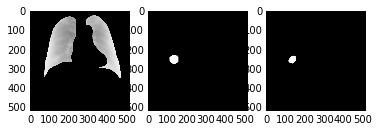

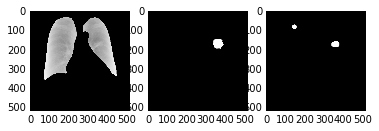

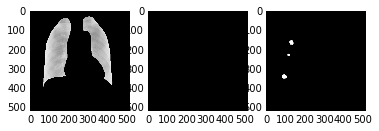

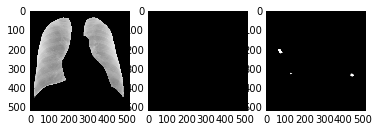

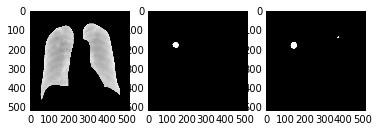

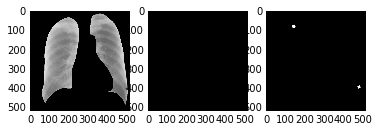

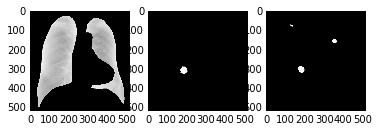

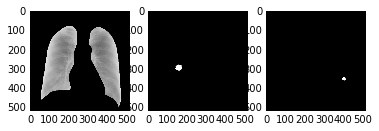

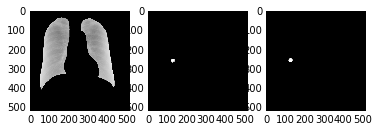

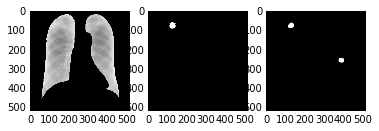

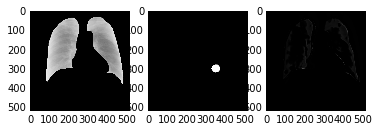

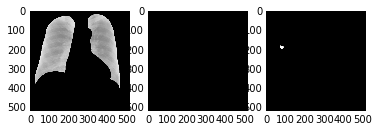

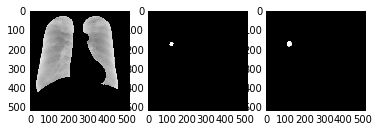

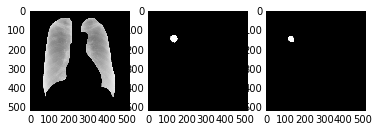

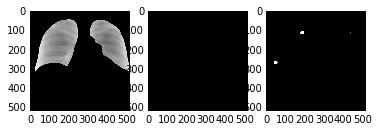

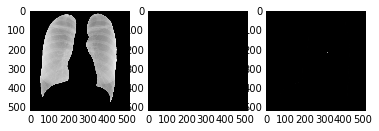

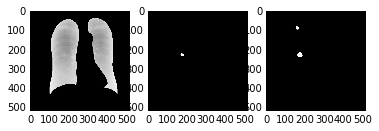

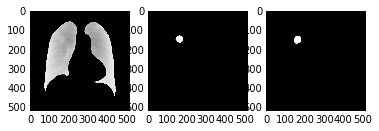

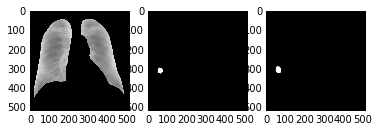

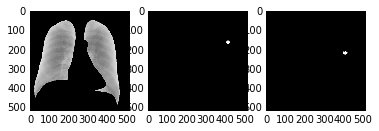

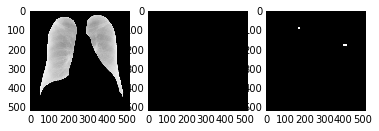

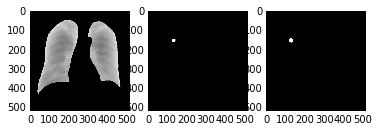

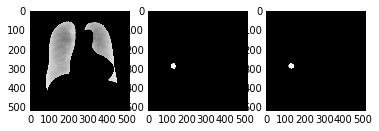

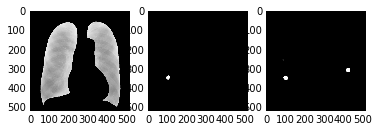

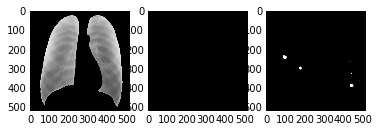

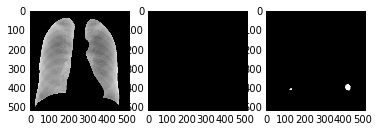

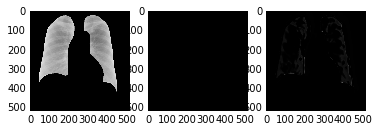

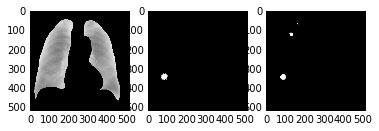

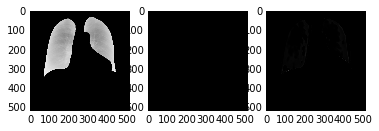

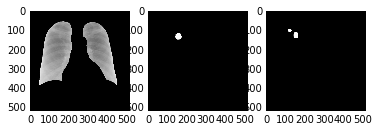

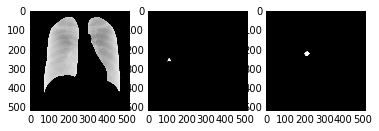

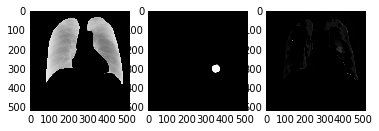

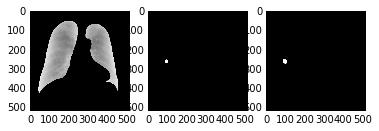

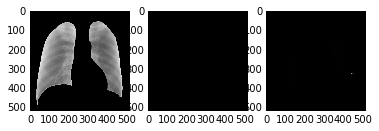

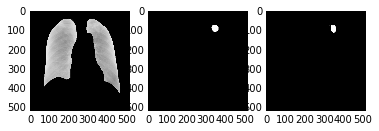

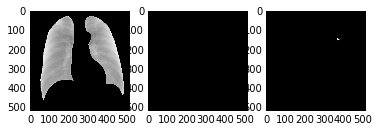

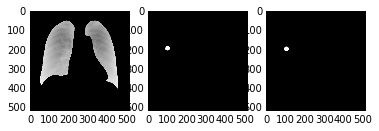

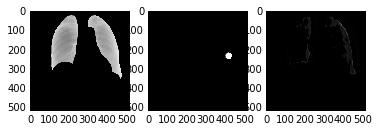

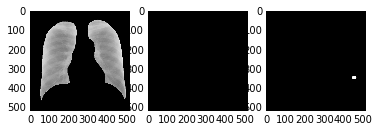

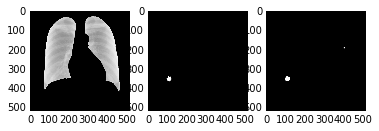

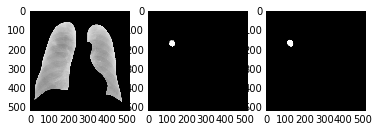

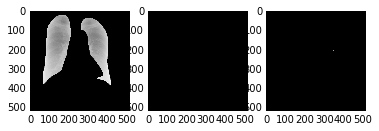

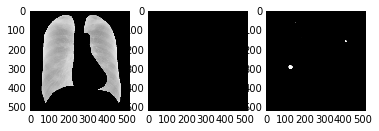

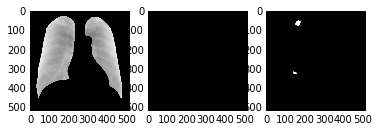

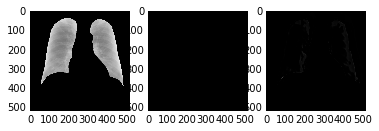

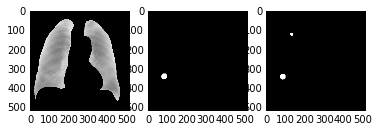

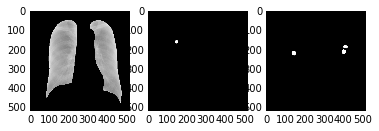

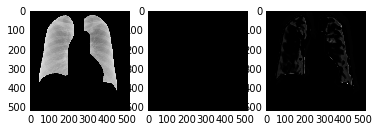

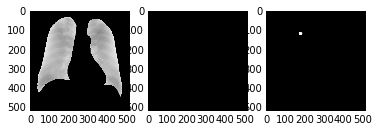

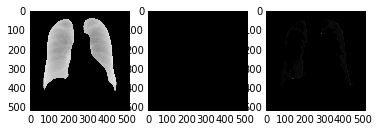

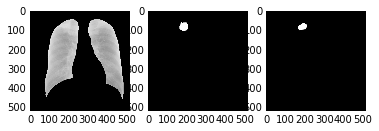

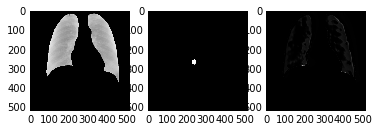

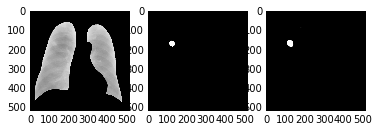

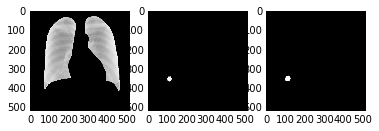

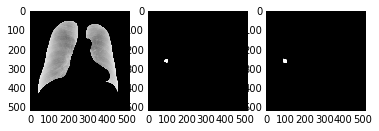

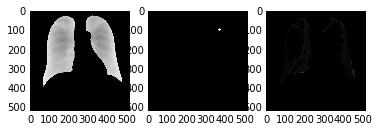

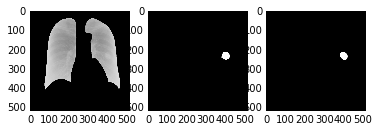

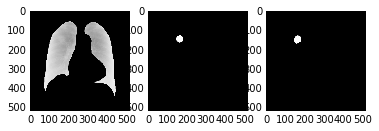

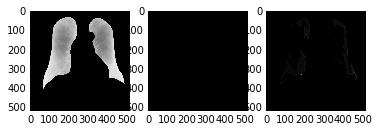

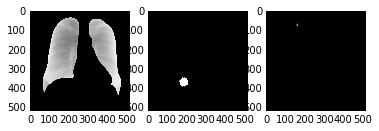

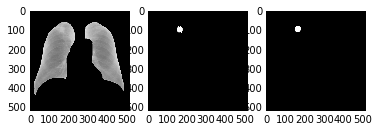

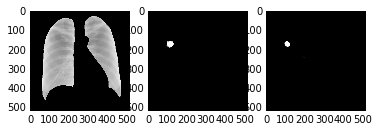

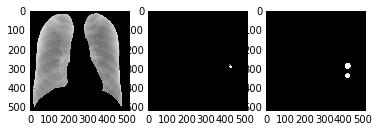

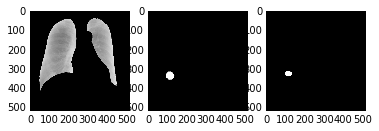

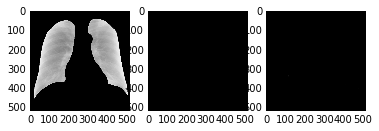

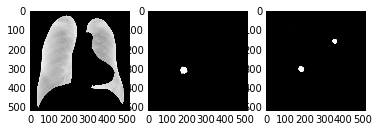

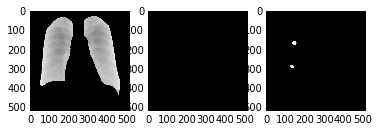

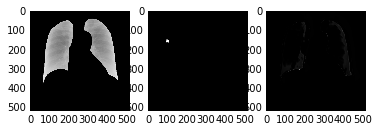

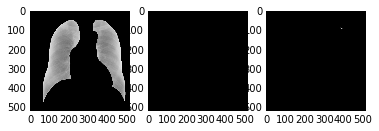

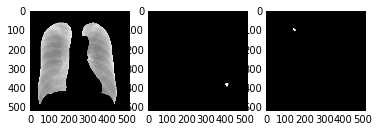

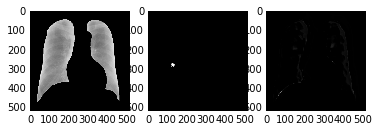

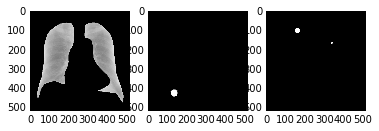

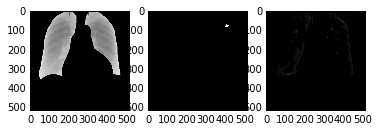

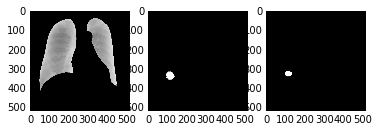

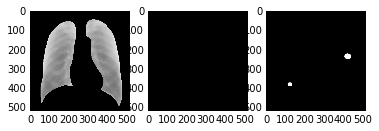

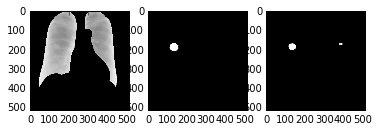

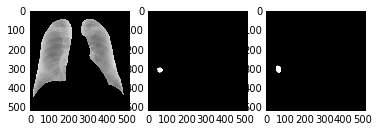

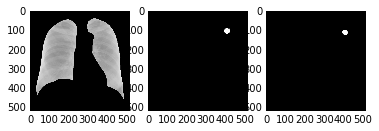

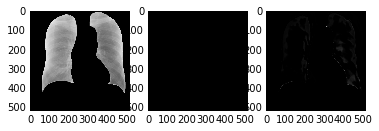

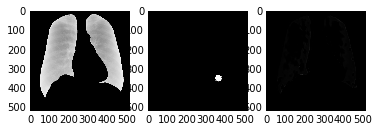

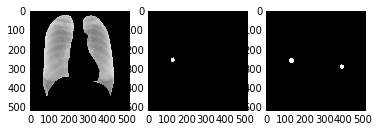

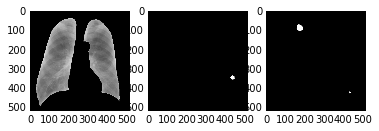

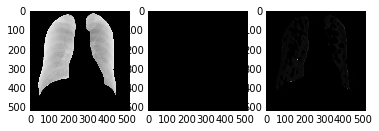

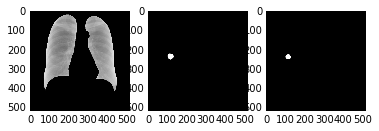

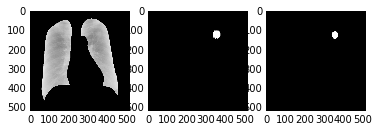

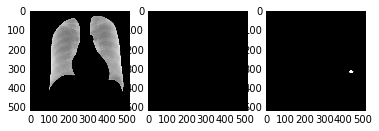

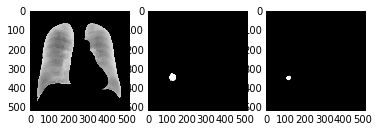

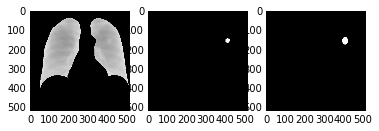

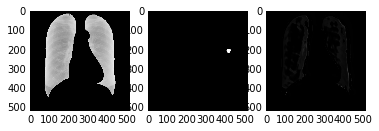

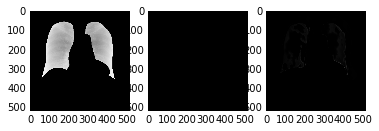

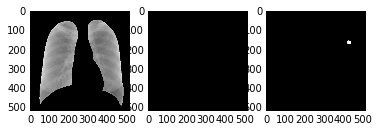

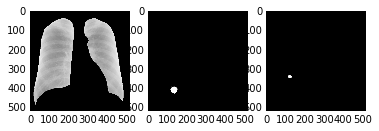

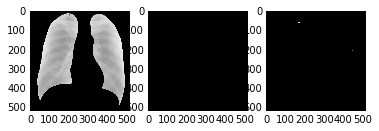

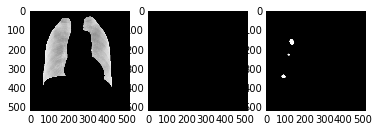

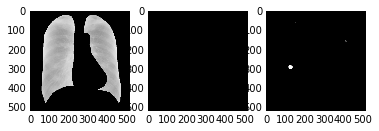

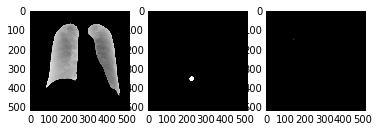

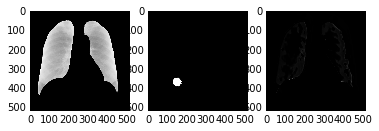

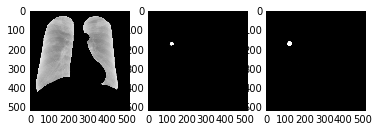

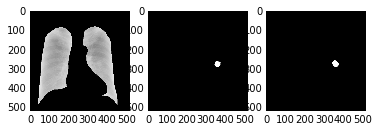

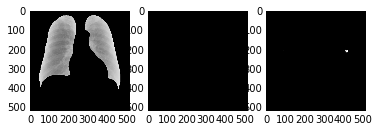

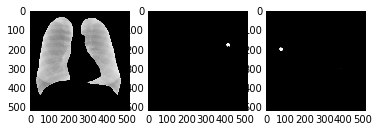

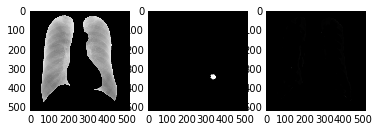

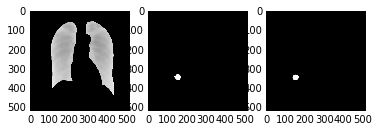

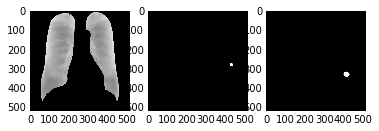

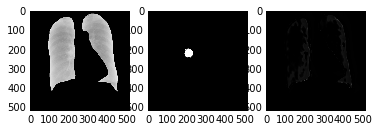

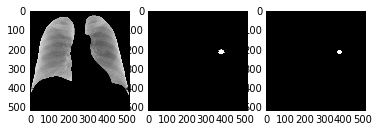

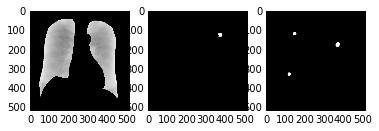

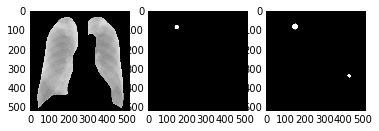

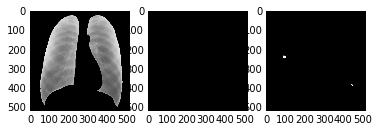

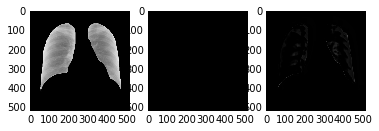

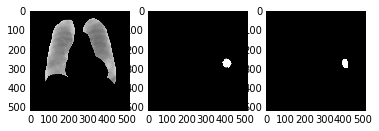

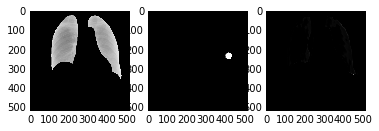

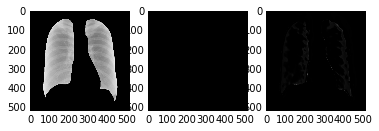

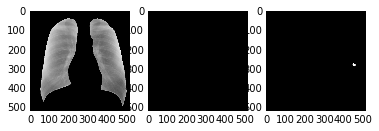

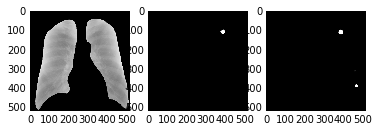

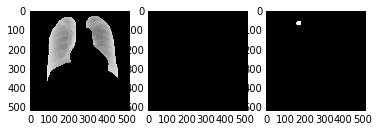

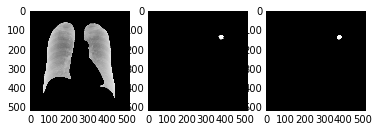

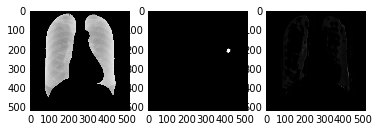

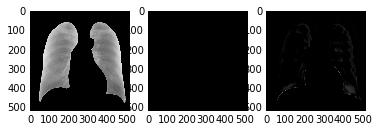

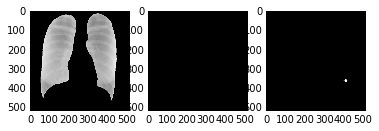

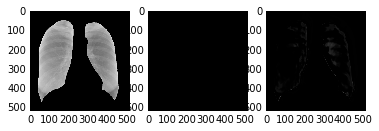

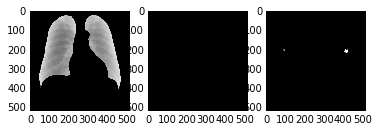

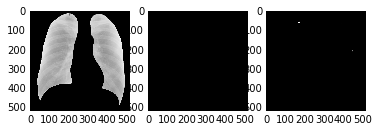

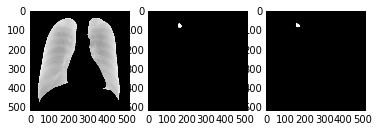

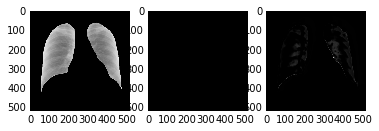

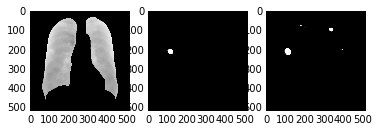

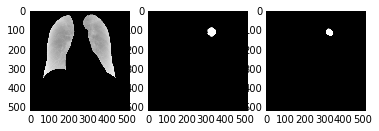

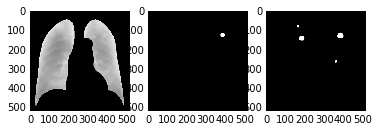

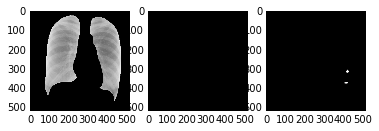

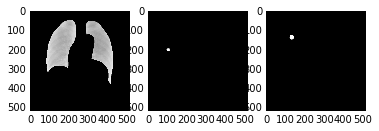

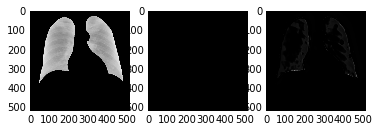

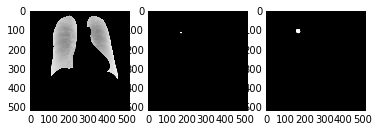

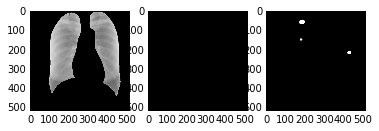

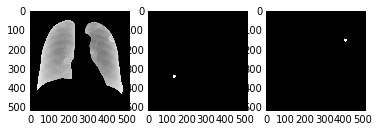

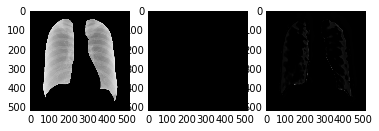

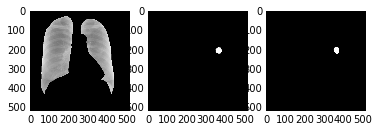

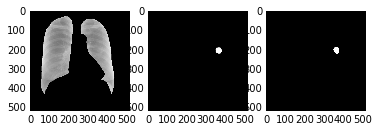

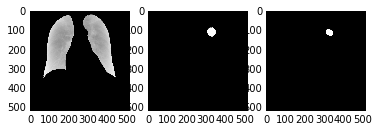

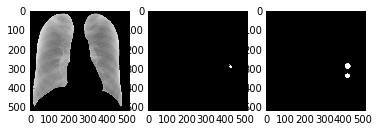

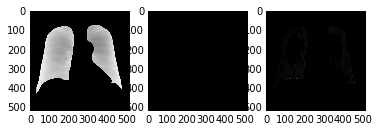

INFO:tensorflow:Error reported to Coordinator: <class 'tensorflow.python.framework.errors_impl.CancelledError'>, Enqueue operation was cancelled
	 [[Node: input_producer_1/input_producer_1_EnqueueMany = QueueEnqueueManyV2[Tcomponents=[DT_STRING], timeout_ms=-1, _device="/job:localhost/replica:0/task:0/device:CPU:0"](input_producer_1, input_producer_1/RandomShuffle)]]


In [27]:
# import time
# logdir='./fengkai/Unet_nodule'
# ckdir ='./fengkai/Unet_nodule_model'
# if not os.path.exists(logdir):
#     os.mkdir(logdir)

# current_time = time.strftime("%m/%d/%H/%M/%S")
# train_logdir = os.path.join(logdir, "train", current_time)
# test_logdir = os.path.join(logdir, "test", current_time)
# # parameter setting
# n_train=223
# n_test=24
# new_height=512
# new_width=new_height
# epochs=1
# batch_size=1
# tf.reset_default_graph()
# X = tf.placeholder(tf.float32, shape=[None, new_width, new_height, 1], name="X")
# y = tf.placeholder(tf.float32, shape=[None, new_width, new_height, 1], name="y")
# mode = tf.placeholder(tf.bool, name="mode")

# pred = make_unet(X, mode)

# tf.add_to_collection("inputs", X)
# tf.add_to_collection("inputs", mode)
# tf.add_to_collection("outputs", pred)

# tf.summary.histogram("Predicted_Mask", pred)
# tf.summary.image("Predicted_Mask", pred)

# update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)

# with tf.control_dependencies(update_ops):
#     train_op = make_train_op(pred, y)

# IOU_op = IOU_(pred, y)
# IOU_op = tf.Print(IOU_op, [IOU_op])
# tf.summary.scalar("IOU", IOU_op)





# #train image mask batch op
# #train image mask batch op
# train_tfrecords_filename = './fengkai/lung_nodule_training.tfrecords'
# train_img_batch_op,train_mask_batch_op=read_and_decode(train_tfrecords_filename,if_aug=True,new_height=new_height,new_width=new_width,batch_size=batch_size)
# #test image mask batch op
# test_tfrecords_filename = './fengkai/lung_nodule_testing.tfrecords'
# test_img_batch_op,test_mask_batch_op=read_and_decode(test_tfrecords_filename,if_aug=False,new_height=new_height,new_width=new_width,batch_size=batch_size)


# summary_op = tf.summary.merge_all()
# config = tf.ConfigProto()
# config.gpu_options.allow_growth = True
# session = tf.Session(config=config)
# with session as sess:
#     # Start populating the filename queue.
#     train_summary_writer = tf.summary.FileWriter(train_logdir, sess.graph)
#     test_summary_writer = tf.summary.FileWriter(test_logdir)

# #     coord = tf.train.Coordinator()
# #     threads = tf.train.start_queue_runners(coord=coord)
#     sess.run(tf.global_variables_initializer())
#     saver = tf.train.Saver()
#     if os.path.exists(ckdir) and tf.train.checkpoint_exists(ckdir):
#         latest_check_point = tf.train.latest_checkpoint(ckdir)
#         saver.restore(sess, latest_check_point)

#         global_step = tf.train.get_global_step(sess.graph)

#         coord = tf.train.Coordinator()
#         threads = tf.train.start_queue_runners(coord=coord)

#         for epoch in range(epochs):

#             for step in range(0, n_train, batch_size):
#                 X_test, y_test = sess.run([train_img_batch_op,train_mask_batch_op])
#                 image,label,predict = sess.run(
#                     [X,y,pred],
#                     feed_dict={X: X_test,
#                                y: y_test,
#                                mode: False})
#                 plt.subplot(131)
#                 plt.imshow(image[0,:,:,0],cmap='gray')
#                 plt.subplot(132)
#                 plt.imshow(label[0,:,:,0],cmap='gray')
#                 plt.subplot(133)
#                 plt.imshow(predict[0,:,:,0],cmap='gray')
#                 plt.show()